# 1. Laden der Daten
Die Daten für die Visualisierungen werden aus dem CSV ML_Data geladen und die Spaltennamen kürzer gemacht

In [52]:
import pandas as pd
# Load data from csv
df  = pd.read_csv("data/ML/ML_Data.csv")
# Give the columns with the important weather data shorter names
df.rename(columns={"Air temperature 2 m above ground daily mean": "air temperature", "Relative air humidity 2 m above ground daily mean": "air humidity",
"Wind speed scalar daily mean in m/s": "wind speed","Precipitation daily total 0 UTC - 0 UTC": "precipitation"}, inplace=True)


# 2. Visualisieren

## 2.1 Heatmap - Durchschnittswerte pro Standort und Cluster
Um die Wetter- und Schadstoffdaten zu vergleichen werden die Daten nach Cluster und Location gruppiert und dann die Durchschnittswerte gebildet.
Die Durchschnittswerte werden dann in separate Heatmaps pro Standort geplottet.

Wenn man die Wetterdaten der vier Cluster vergleicht, sieht man, dass das Wetter sehr ähnlich in Zürich und St. Gallen ist. Zürich ist ein wenig wärmer und hat weniger Niederschlag

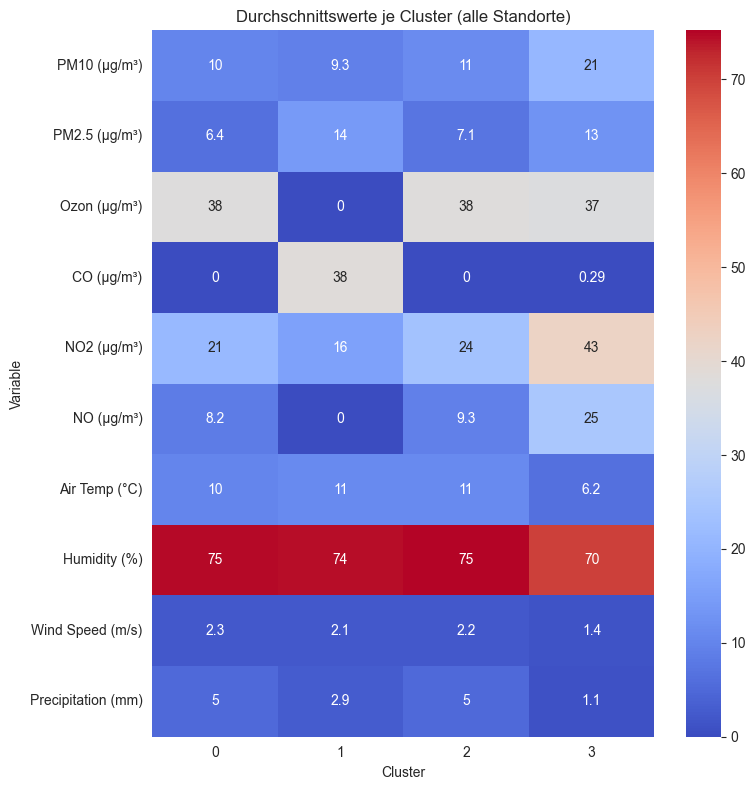

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define variable names and their physical units
label_map = {
    "PM10": "PM10 (µg/m³)",
    "PM2_5": "PM2.5 (µg/m³)",
    "Ozon": "Ozon (µg/m³)",
    "CO": "CO (µg/m³)",
    "NO2": "NO2 (µg/m³)",
    "NO": "NO (µg/m³)",
    "air temperature": "Air Temp (°C)",
    "air humidity": "Humidity (%)",
    "wind speed": "Wind Speed (m/s)",
    "precipitation": "Precipitation (mm)"
}

# 🧠 Gruppierung NUR nach Cluster (ohne location!)
cluster_means = df.groupby("cluster")[[
    "PM10", "PM2_5",  "Ozon", "CO", "NO2", "NO",
    "air temperature",
    "air humidity",
    "wind speed",
    "precipitation"
]].mean().reset_index()

# 📊 Für die Heatmap vorbereiten
heatmap_data = cluster_means.set_index("cluster").T
heatmap_data.index = heatmap_data.index.map(label_map)

# 🎨 Eine gemeinsame Heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.title("Durchschnittswerte je Cluster (alle Standorte)")
plt.xlabel("Cluster")
plt.ylabel("Variable")

plt.tight_layout()
plt.show()


## 2.2 Streudiagramm - Zusammenhang Wetter und Schadstoffe nach Cluster und Location
Um zu prüfen, ob die einzelnen Wetterfaktoren einen Einfluss auf die Schadstoffwerte haben, wurde 3x4 Plots erstellt. An der y-Achse die Wetterfaktoren und an der x-Achse die Schadstoffwerte. Diese Art von Diagramm nennt man Streudiagramm

Bei der Temperatur und Luftfeuchtigkeit kann keine Abhängigkeit zwischen dem Wetterfaktor und den Schadstoffwerten festgestellt werden.
Für die Windgeschwindigkeit und den Niederschlag kann man eine umgekehrt proportionale Abhängigkeit erkennen. Je höher der Wetterfaktor ist, desto kleiner die Schadstoffwerte.

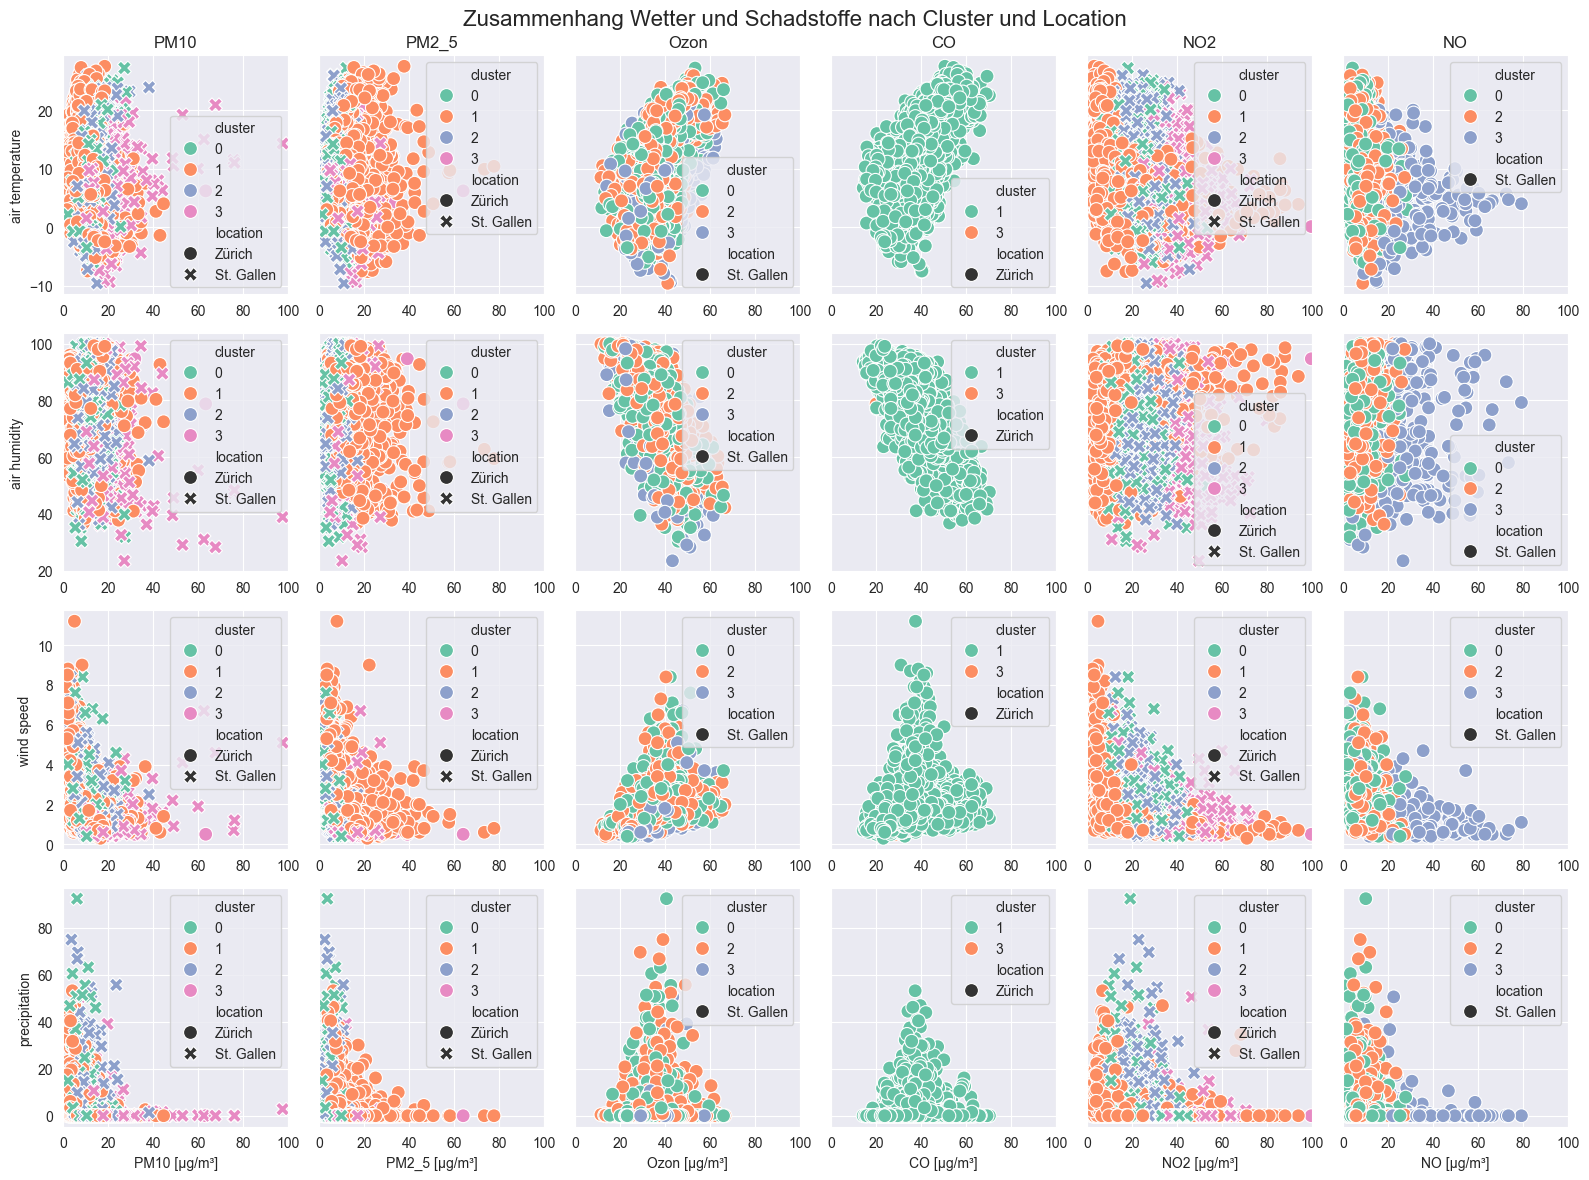

In [54]:
# Definition of weather and pollutants columns
weather_vars = ["air temperature", "air humidity", "wind speed", "precipitation"]
pollutants = ["PM10", "PM2_5",  "Ozon", "CO", "NO2", "NO"]

# Generate the subplots with rows for weather and columns for pollutants
fig, axs = plt.subplots(len(weather_vars), len(pollutants), figsize=(16, 12), sharey='row')

# Loop through all weather columns
for i, w_var in enumerate(weather_vars):
    # Loop thru all pollutants columns
    for j, p_var in enumerate(pollutants):
        ax = axs[i, j]

        filtered_df = df[df[p_var] != 0]

        sns.scatterplot(
                data=filtered_df,
                x=p_var,
                y=w_var,
                hue="cluster",
                style="location",
                palette="Set2",
                markers=True,
                s=100,
                ax=ax
            )

        ax.set_xlim(0, 100)  # <-- Set x-axis limits
        # Show on top and bottom the labels for pollutants and on the right side for the weather data
        if i == 0:
            ax.set_title(p_var)
        if j == 0:
            ax.set_ylabel(w_var)
        else:
            ax.set_ylabel('')
        if i < len(weather_vars) - 1:
            ax.set_xlabel('')  # only the bottom row shows x label
        else:
            ax.set_xlabel(f"{p_var} [µg/m³]")

plt.suptitle("Zusammenhang Wetter und Schadstoffe nach Cluster und Location", fontsize=16)
plt.tight_layout()
plt.show()


## 2.3 Boxplot - Schadstoffe
Um zu überprüfen, wie die Verteilung der Schadstoffwerte in den Cluster ist, wurde ein Boxplot erstellt.

Die Boxen sind im Vergleich zu den Whisker klein. Vor allem die oberen Whisker sind sehr lang. Dies bedeutet, dass die meisten Daten sehr ähnlich sind es aber gegen oben einige Werte deutlich abweichen.

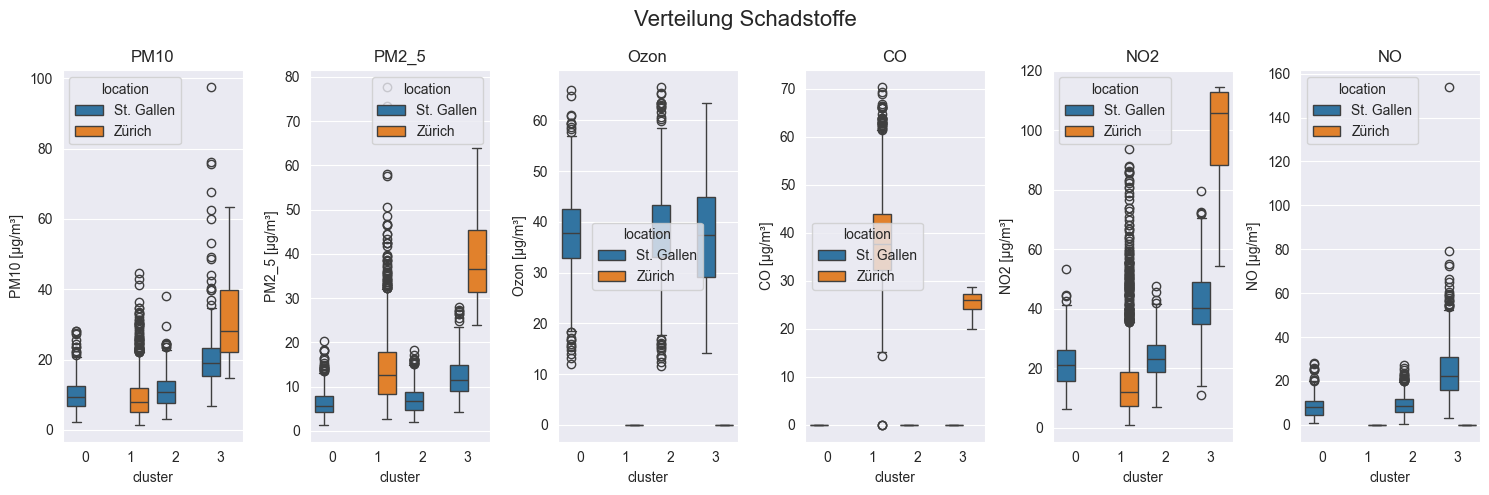

In [55]:
# Generate the subplots for every pollutant
fig, axs = plt.subplots(1, len(pollutants), figsize=(15, 5))  # 1 row, 3 columns
# Loop through the pollutants and make the boxplots
for i, col in enumerate(pollutants):
    ax = axs[i]
    sns.boxplot(data=df, x="cluster", y=col, hue="location", ax=ax)
    ax.set_title(col)
    ax.set_ylabel(f"{col} [µg/m³]")

plt.suptitle("Verteilung Schadstoffe", fontsize=16)
plt.tight_layout()
plt.show()


## 2.4 Streudiagramm - Wetterindex
Um zu prüfen, ob es einen Zusammenhang zwischen schönem Wetter und den Schadstoffen gibt, wurde ein Wetterindex berechnet.<br>
Ein hoher Wetterindex bedeutet gutes Wetter. Die Wetterfaktoren wurden wie folgt gewertet:<br>
Temperatur = hohe Temperature bedeutet gutes Wetter<br>
Windgeschwindigkeit = Tiefe Windgeschwindigkeiten bedeutet gutes Wetter<br>
Niederschlag = Tiefer Niederschlag bedeutet gutes Wetter<br>
Luftfeuchtigkeit = 50 % Luftfeuchtigkeit ist ideal<br>

Der Wetterindex wird dann als Streudiagramm mit den Schadstoffwerten verglichen.

Es ist gut zu erkennen, dass die meisten Punkte mit einem hohen Schadstoffwert einen hohen Wetterindex haben. Somit kann man sagen, dass hohe Schadstoffwerte hauptsächlich bei gutem Wetter vorkommen.

In [56]:
from sklearn.preprocessing import StandardScaler
import numpy as np

weather_vars = ["air temperature", "air humidity", "wind speed", "precipitation"]

# Copy to avoid changing original df
weather_data = df[weather_vars].copy()

# Invert wind speed and precipitation (so lower values are better)
weather_data["wind speed"] = -weather_data["wind speed"]
weather_data["precipitation"] = -weather_data["precipitation"]

# Transform humidity: highest score at 50%
humidity_ideal = 50
weather_data["air humidity"] = -((weather_data["air humidity"] - humidity_ideal) ** 2)

# Standardize all variables
scaler = StandardScaler()
weather_scaled = scaler.fit_transform(weather_data)

# Combine into weather index
df['weather_index'] = np.mean(weather_scaled, axis=1)


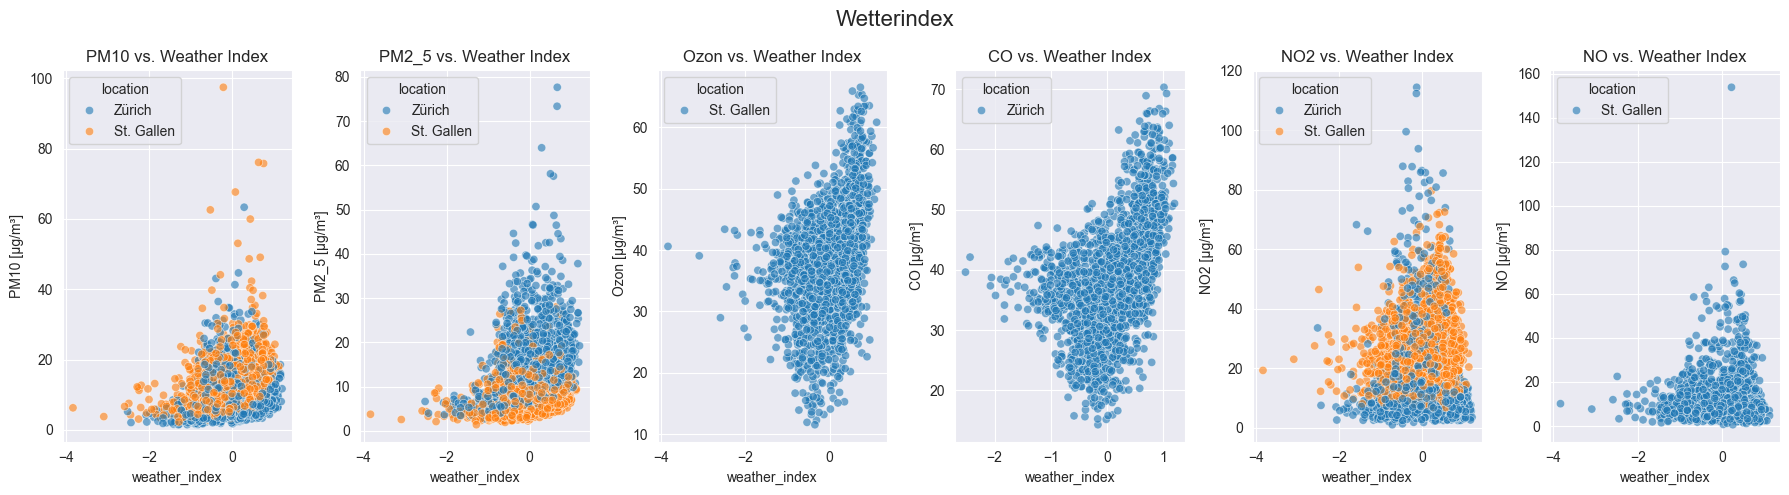

In [58]:
# Generate the subplots for every pollutant
fig, axs = plt.subplots(1, len(pollutants), figsize=(18, 5), sharey=False)

# Loop through the pollutants and make the scatter plots
for i, pollutant in enumerate(pollutants):
    ax = axs[i]
    filtered_df = df[df[pollutant] != 0]
    sns.scatterplot(data=filtered_df, x="weather_index", y=pollutant, hue="location", alpha=0.6, ax=ax)
    ax.set_ylabel(f"{pollutant} [µg/m³]")
    ax.set_title(f"{pollutant} vs. Weather Index")

plt.suptitle("Wetterindex", fontsize=16)
plt.tight_layout()
plt.show()
